# EDA

Investigar sobre:

* Hedonic pricing
* Rosen model

In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import folium


import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder


def mean_absolute_percentage_error(y_pred, y_true):
    y_true = np.where(y_true == 0, 0.0000000001, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true))


plt.rcParams['figure.figsize'] = (16,10)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [7]:
RIDICULOUS_PRICE = 5000000000
RIRIDULOUS_AREA = 10000

train = pd.read_csv("../data/train_data.csv")
train['highPrice'] = np.where(train['valorventa'] > 500000000, "High", "Normal")
train['priceMT2'] = train['valorventa'] / train['area']
train['priceMT2log'] = np.log1p(train['priceMT2'])

train = train[(train['valorventa'] < RIDICULOUS_PRICE) &
              (train['area'] < RIRIDULOUS_AREA)]
train.replace([np.inf], np.nan, inplace=True)
train.dropna(subset=['priceMT2'], inplace=True)

In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243669 entries, 0 to 244487
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     243669 non-null  int64  
 1   area                   243669 non-null  float64
 2   ascensor               87394 non-null   float64
 3   balcon                 59938 non-null   float64
 4   banos                  242276 non-null  float64
 5   banoservicio           12202 non-null   float64
 6   conjuntocerrado        243669 non-null  int64  
 7   cuartoservicio         55344 non-null   float64
 8   deposito               107233 non-null  float64
 9   estrato                236346 non-null  float64
 10  estudio                76530 non-null   float64
 11  garajes                212491 non-null  float64
 12  gimnasio               72583 non-null   float64
 13  habitaciones           242962 non-null  float64
 14  halldealcobas          64475 non-nul

In [71]:
train['garajes'].fillna(0,inplace=True).value_counts()

1.000     84078
2.000     81956
0.000     40119
3.000     20186
4.000     12465
5.000       643
6.000       469
8.000       119
7.000       112
10.000       67
9.000        23
Name: garajes, dtype: int64

In [83]:
train[train['tipoinmueble'] =="Casa"]['tiempodeconstruido'].value_counts()

Entre 10 y 20 años    9014
16 a 30 años          8920
Más de 30 años        6687
9 a 15 años           6102
Más de 20 años        4914
1 a 8 años            2552
Entre 5 y 10 años     1701
Entre 0 y 5 años       783
Remodelado             751
Menos de 1 año         554
Name: tiempodeconstruido, dtype: int64

In [32]:
train[train['tipoinmueble'] =="Casa"]['priceMT2'].describe()

count    5.671700e+04
mean     4.020582e+06
std      2.535258e+07
min      1.226994e+04
25%      2.257143e+06
50%      3.323650e+06
75%      4.388889e+06
max      3.800000e+09
Name: priceMT2, dtype: float64

In [9]:
train.isna().sum() / train.shape[0]

id                       0.000000
area                     0.000000
ascensor                 0.641143
balcon                   0.753974
banos                    0.005667
banoservicio             0.950059
conjuntocerrado          0.000000
cuartoservicio           0.774644
deposito                 0.559472
estrato                  0.030060
estudio                  0.686996
garajes                  0.128558
gimnasio                 0.702653
habitaciones             0.002786
halldealcobas            0.736094
parqueaderovisitantes    0.754210
piscina                  0.928868
piso                     0.486559
porteria                 0.922458
remodelado               0.904917
saloncomunal             0.552727
terraza                  0.826284
tiempodeconstruido       0.247200
vigilancia               0.413241
vista                    0.581332
zonalavanderia           0.393121
valoradministracion      0.114567
valorventa               0.000000
tipoinmueble             0.000000
tiponegocio   

In [58]:
train

,id,area,ascensor,balcon,banos,banoservicio,conjuntocerrado,cuartoservicio,deposito,estrato,...,vista,zonalavanderia,valoradministracion,valorventa,tipoinmueble,tiponegocio,latitud,longitud,highPrice,priceMT2
0,1205404,55.0,NaN,NaN,NaN,NaN,0,NaN,1.0,3.0,...,NaN,1.0,50000.0,1.699500e+08,Casa,Venta,4.560965,-74.094889,Normal,3.090000e+06
1,1204371,43.0,NaN,NaN,NaN,NaN,0,NaN,0.0,NaN,...,NaN,NaN,0.0,9.000000e+07,Casa,Venta,4.576960,-74.100083,Normal,2.093023e+06
2,1125353,360.0,NaN,NaN,NaN,NaN,0,NaN,0.0,3.0,...,NaN,NaN,0.0,1.100000e+09,Casa,Venta,4.575000,-74.101000,High,3.055556e+06
3,1125506,60.0,NaN,NaN,NaN,1.0,0,1.0,0.0,3.0,...,NaN,NaN,0.0,2.600000e+08,Apartamento,Venta,4.575924,-74.108039,Normal,4.333333e+06
4,1204569,72.0,NaN,NaN,NaN,NaN,0,NaN,0.0,2.0,...,NaN,1.0,0.0,1.250000e+08,Casa,Venta,4.559000,-74.097000,Normal,1.736111e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244483,6262941,235.0,NaN,NaN,4.0,NaN,0,1.0,NaN,4.0,...,NaN,1.0,NaN,8.056924e+08,Casa,Venta,4.737393,-74.038282,High,3.428478e+06
244484,6262942,225.0,NaN,NaN,4.0,NaN,0,1.0,NaN,4.0,...,NaN,1.0,NaN,7.509566e+08,Casa,Venta,4.734240,-74.038518,High,3.337585e+06
244485,6262943,235.0,NaN,NaN,4.0,NaN,0,1.0,NaN,4.0,...,NaN,1.0,NaN,7.525618e+08,Casa,Venta,4.736392,-74.040659,High,3.202391e+06
244486,6262944,232.0,NaN,NaN,4.0,NaN,0,1.0,NaN,4.0,...,NaN,1.0,NaN,7.049425e+08,Casa,Venta,4.737524,-74.040292,High,3.038545e+06


In [47]:
np.quantile(train['area'], 0.99)

nan

In [51]:
train.describe(include='all')

,id,area,ascensor,balcon,banos,banoservicio,conjuntocerrado,cuartoservicio,deposito,estrato,...,vista,zonalavanderia,valoradministracion,valorventa,tipoinmueble,tiponegocio,latitud,longitud,highPrice,priceMT2
count,2.436690e+05,243669.000000,87394.0,59938.0,242276.000000,12202.0,243669.000000,55344.0,107233.000000,236346.000000,...,101978,147768.0,2.155130e+05,2.436690e+05,243669,242900,243669.000000,243669.000000,243669,2.436690e+05
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,NaN,NaN,NaN,2,4,NaN,NaN,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Exterior,NaN,NaN,NaN,Apartamento,Venta,NaN,NaN,Normal,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,79843,NaN,NaN,NaN,186255,231766,NaN,NaN,121917,NaN
mean,6.022807e+05,151.351532,1.0,1.0,2.793628,1.0,0.319856,1.0,0.873388,4.402617,...,NaN,1.0,2.255721e+06,7.654023e+08,NaN,NaN,4.686660,-74.072320,NaN,5.547770e+06
std,4.054395e+05,214.691319,0.0,0.0,1.662693,0.0,0.466422,0.0,0.332540,1.321793,...,NaN,0.0,5.842945e+07,7.999841e+08,NaN,NaN,0.048998,0.038240,NaN,2.573209e+07
min,6.000000e+00,0.000000,1.0,1.0,0.000000,1.0,0.000000,1.0,0.000000,0.000000,...,NaN,1.0,0.000000e+00,5.300000e+07,NaN,NaN,3.890660,-74.362167,NaN,0.000000e+00
25%,2.834050e+05,69.000000,1.0,1.0,2.000000,1.0,0.000000,1.0,1.000000,3.000000,...,NaN,1.0,5.000000e+04,3.000000e+08,NaN,NaN,4.657966,-74.090210,NaN,3.586957e+06
50%,5.302930e+05,105.000000,1.0,1.0,3.000000,1.0,0.000000,1.0,1.000000,4.000000,...,NaN,1.0,2.900000e+05,5.000000e+08,NaN,NaN,4.695000,-74.058998,NaN,4.791667e+06
75%,9.068150e+05,183.000000,1.0,1.0,4.000000,1.0,1.000000,1.0,1.000000,6.000000,...,NaN,1.0,6.076000e+05,9.000000e+08,NaN,NaN,4.720134,-74.045471,NaN,6.301370e+06


In [52]:
train['tipoinmueble'].value_counts()

Apartamento    186255
Casa            57414
Name: tipoinmueble, dtype: int64

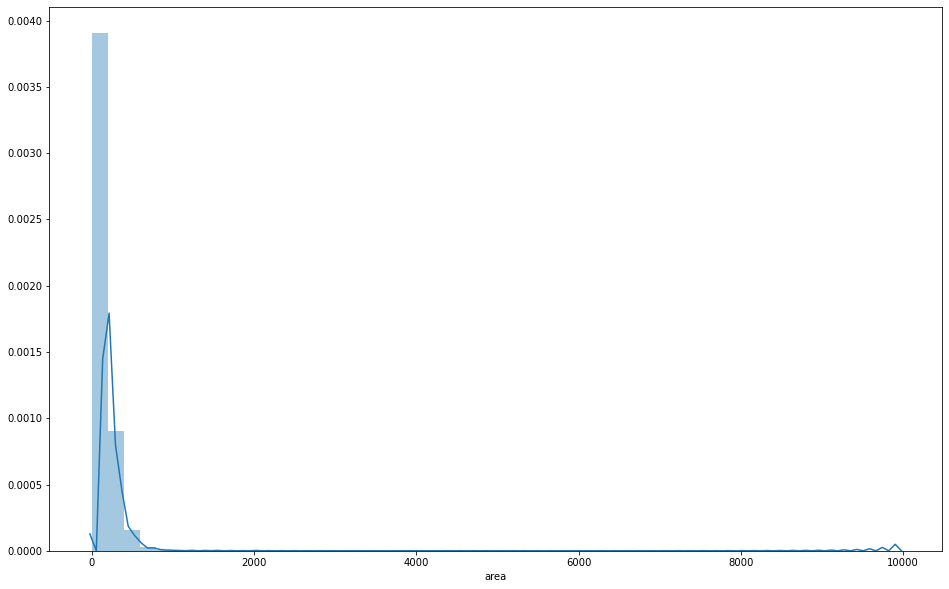

In [53]:
sns.distplot(train['area'])

In [23]:
train[train['valorventa'] < 1000000000]

,id,area,ascensor,balcon,banos,banoservicio,conjuntocerrado,cuartoservicio,deposito,estrato,...,tiempodeconstruido,vigilancia,vista,zonalavanderia,valoradministracion,valorventa,tipoinmueble,tiponegocio,latitud,longitud
0,1205404,55.0,NaN,NaN,NaN,NaN,0,NaN,1.0,3.0,...,NaN,NaN,NaN,1.0,50000.0,169950000.0,Casa,Venta,4.560965,-74.094889
1,1204371,43.0,NaN,NaN,NaN,NaN,0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,0.0,90000000.0,Casa,Venta,4.576960,-74.100083
3,1125506,60.0,NaN,NaN,NaN,1.0,0,1.0,0.0,3.0,...,NaN,NaN,NaN,NaN,0.0,260000000.0,Apartamento,Venta,4.575924,-74.108039
4,1204569,72.0,NaN,NaN,NaN,NaN,0,NaN,0.0,2.0,...,NaN,NaN,NaN,1.0,0.0,125000000.0,Casa,Venta,4.559000,-74.097000
5,1161678,126.0,NaN,NaN,NaN,1.0,0,NaN,1.0,3.0,...,NaN,NaN,Exterior,1.0,0.0,600000000.0,Casa,Venta,4.588146,-74.107008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244483,6262941,235.0,NaN,NaN,4.0,NaN,0,1.0,NaN,4.0,...,Más de 20 años,NaN,NaN,1.0,NaN,805692395.0,Casa,Venta,4.737393,-74.038282
244484,6262942,225.0,NaN,NaN,4.0,NaN,0,1.0,NaN,4.0,...,Más de 20 años,NaN,NaN,1.0,NaN,750956587.0,Casa,Venta,4.734240,-74.038518
244485,6262943,235.0,NaN,NaN,4.0,NaN,0,1.0,NaN,4.0,...,Más de 20 años,NaN,NaN,1.0,NaN,752561771.0,Casa,Venta,4.736392,-74.040659
244486,6262944,232.0,NaN,NaN,4.0,NaN,0,1.0,NaN,4.0,...,Más de 20 años,NaN,NaN,1.0,NaN,704942538.0,Casa,Venta,4.737524,-74.040292


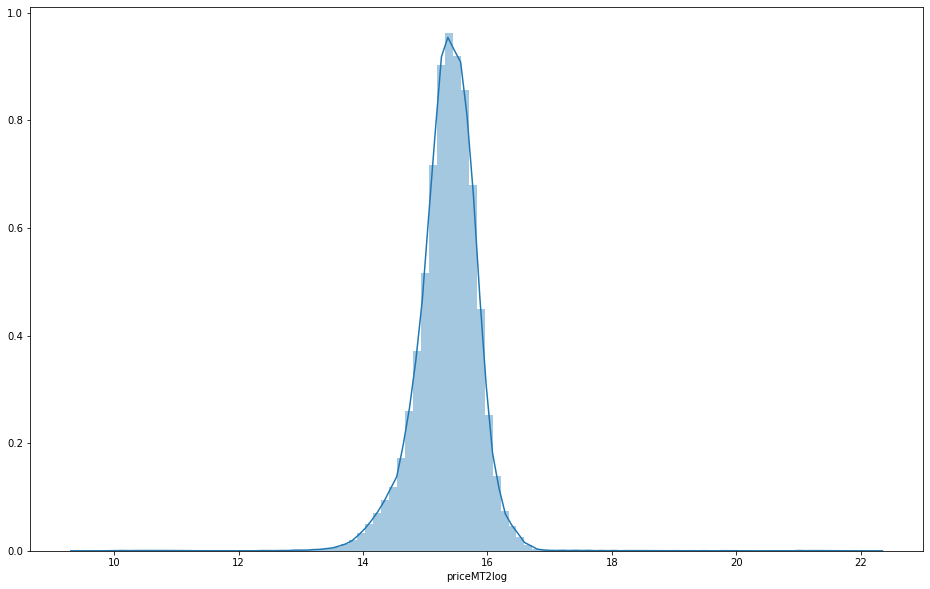

In [140]:
sns.distplot(train['priceMT2log'], bins=100)

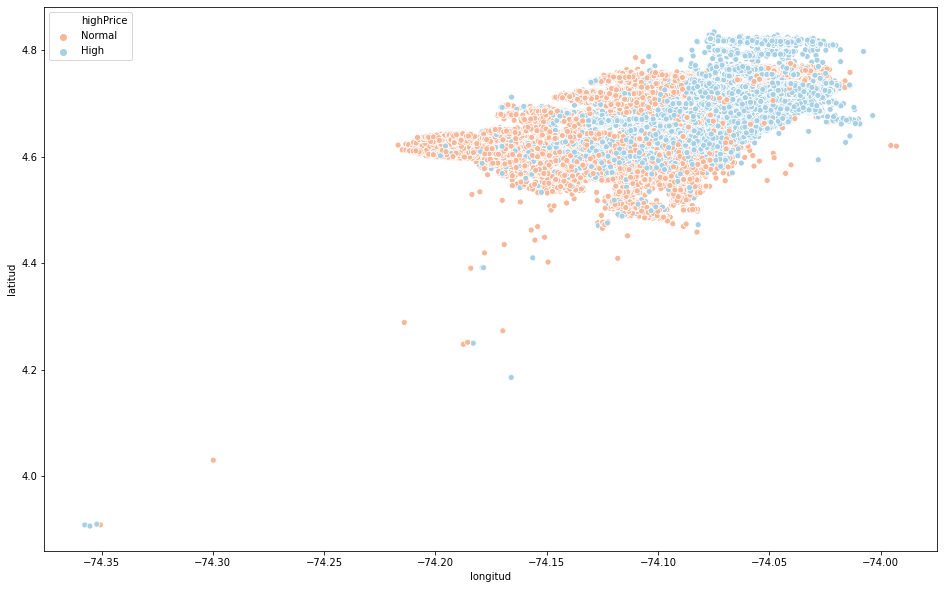

In [139]:
sns.scatterplot(x='longitud',y= 'latitud', data= houses_only, hue = 'highPrice', palette='RdBu')

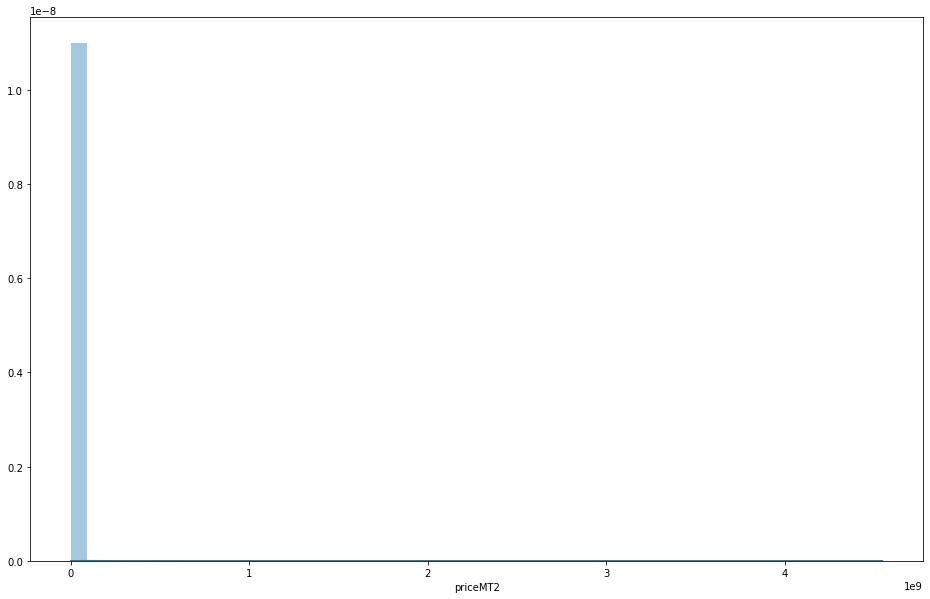

In [56]:
sns.distplot(train['priceMT2'])

In [57]:
train.corr()

,id,area,ascensor,balcon,banos,banoservicio,conjuntocerrado,cuartoservicio,deposito,estrato,...,remodelado,saloncomunal,terraza,vigilancia,zonalavanderia,valoradministracion,valorventa,latitud,longitud,priceMT2
id,1.000000,-0.005696,NaN,NaN,-0.018758,NaN,-0.015098,NaN,-0.422272,-0.145239,...,NaN,NaN,NaN,0.005705,NaN,-0.006409,-0.069425,-0.045630,-0.107528,-0.014714
area,-0.005696,1.000000,NaN,NaN,0.265818,NaN,-0.048374,NaN,-0.022572,0.130365,...,NaN,NaN,NaN,-0.006437,NaN,0.017399,0.415806,0.014952,0.062201,-0.013798
ascensor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balcon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
banos,-0.018758,0.265818,NaN,NaN,1.000000,NaN,-0.051116,NaN,0.019724,0.267767,...,NaN,NaN,NaN,0.009162,NaN,0.014930,0.414353,0.062423,0.161035,0.028517
banoservicio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
conjuntocerrado,-0.015098,-0.048374,NaN,NaN,-0.051116,NaN,1.000000,NaN,0.288136,-0.035845,...,NaN,NaN,NaN,0.232505,NaN,0.000497,-0.048604,0.165834,-0.020128,-0.011948
cuartoservicio,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
deposito,-0.422272,-0.022572,NaN,NaN,0.019724,NaN,0.288136,NaN,1.000000,0.237150,...,NaN,NaN,NaN,0.455879,NaN,0.009553,0.056260,0.116974,0.205792,0.037324
estrato,-0.145239,0.130365,NaN,NaN,0.267767,NaN,-0.035845,NaN,0.237150,1.000000,...,NaN,NaN,NaN,0.059385,NaN,0.024918,0.491055,0.241484,0.634030,0.067290


In [154]:
np.quantile(houses_only['valorventa'],0.99)

5000000000.0

# Baseline model

In [60]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243669 entries, 0 to 244487
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     243669 non-null  int64  
 1   area                   243669 non-null  float64
 2   ascensor               87394 non-null   float64
 3   balcon                 59938 non-null   float64
 4   banos                  242276 non-null  float64
 5   banoservicio           12202 non-null   float64
 6   conjuntocerrado        243669 non-null  int64  
 7   cuartoservicio         55344 non-null   float64
 8   deposito               107233 non-null  float64
 9   estrato                236346 non-null  float64
 10  estudio                76530 non-null   float64
 11  garajes                212491 non-null  float64
 12  gimnasio               72583 non-null   float64
 13  habitaciones           242962 non-null  float64
 14  halldealcobas          64475 non-nul

In [84]:
RIDICULOUS_PRICE = 5000000000
RIRIDULOUS_AREA = 10000

train = pd.read_csv("../data/train_data.csv")
train['highPrice'] = np.where(train['valorventa'] > 500000000, "High", "Normal")
train['priceMT2'] = train['valorventa'] / train['area']
train['valorventalog'] = np.log1p(train['valorventa'])
train.replace([np.inf], np.nan, inplace=True)
train.dropna(subset=['priceMT2'], inplace=True)
train = train[train['priceMT2'] < np.quantile(train['priceMT2'], 0.99)]
train['priceMT2log'] = np.log1p(train['priceMT2'])

train = train[(train['valorventa'] < RIDICULOUS_PRICE) &
              (train['area'] < RIRIDULOUS_AREA)]

train

,id,area,ascensor,balcon,banos,banoservicio,conjuntocerrado,cuartoservicio,deposito,estrato,...,valoradministracion,valorventa,tipoinmueble,tiponegocio,latitud,longitud,highPrice,priceMT2,valorventalog,priceMT2log
0,1205404,55.000,nan,nan,nan,nan,0,nan,1.000,3.000,...,50000.000,169950000.000,Casa,Venta,4.561,-74.095,Normal,3090000.000,18.951,14.944
1,1204371,43.000,nan,nan,nan,nan,0,nan,0.000,nan,...,0.000,90000000.000,Casa,Venta,4.577,-74.100,Normal,2093023.256,18.315,14.554
2,1125353,360.000,nan,nan,nan,nan,0,nan,0.000,3.000,...,0.000,1100000000.000,Casa,Venta,4.575,-74.101,High,3055555.556,20.819,14.932
3,1125506,60.000,nan,nan,nan,1.000,0,1.000,0.000,3.000,...,0.000,260000000.000,Apartamento,Venta,4.576,-74.108,Normal,4333333.333,19.376,15.282
4,1204569,72.000,nan,nan,nan,nan,0,nan,0.000,2.000,...,0.000,125000000.000,Casa,Venta,4.559,-74.097,Normal,1736111.111,18.644,14.367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244483,6262941,235.000,nan,nan,4.000,nan,0,1.000,nan,4.000,...,nan,805692395.000,Casa,Venta,4.737,-74.038,High,3428478.277,20.507,15.048
244484,6262942,225.000,nan,nan,4.000,nan,0,1.000,nan,4.000,...,nan,750956587.000,Casa,Venta,4.734,-74.039,High,3337584.831,20.437,15.021
244485,6262943,235.000,nan,nan,4.000,nan,0,1.000,nan,4.000,...,nan,752561771.000,Casa,Venta,4.736,-74.041,High,3202390.515,20.439,14.979
244486,6262944,232.000,nan,nan,4.000,nan,0,1.000,nan,4.000,...,nan,704942538.000,Casa,Venta,4.738,-74.040,High,3038545.422,20.374,14.927


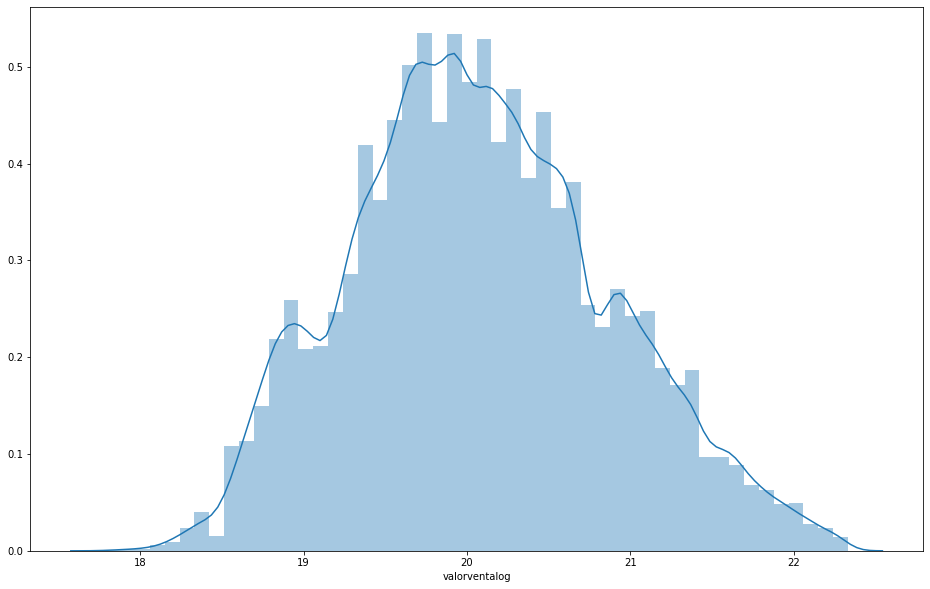

In [85]:
sns.distplot(train['valorventalog'])

In [86]:
class DataFrameBuilder:
    
    RIDICULOUS_PRICE = 5000000000
    RIDICULOUS_AREA = 10000
    
    def __init__(self, dataframe, test=False):
        self.test = test
        self.original_dataframe = dataframe.copy()
        self.modeling_dataframe = None
        
    
    def filterRows(self, dataframe):
        return dataframe[(dataframe['tipoinmueble'] == "Casa") &
                        (dataframe['valorventa'] < DataFrameBuilder.RIDICULOUS_PRICE) &
                          (dataframe['area'] < DataFrameBuilder.RIDICULOUS_AREA) 
                        ]
    
    def createVars(self, dataframe):
        
        cat_vars = ['tiempodeconstruido']

        #dummified = []
        #for var in cat_vars:            
        #    dummified.append(
        #            pd.get_dummies(dataframe[var], drop_first=True, prefix=var)
        #    )

        #dummified = pd.concat(dummified, axis=1)
        #dataframe = pd.concat([dataframe.drop(cat_vars, axis=1),dummified], axis=1)
        #encoder = OneHotEncoder(handle_unknown = 'ignore')


        #for col in dummified.columns:
        #    features.append(col)
            
        #dataframe['priceMT2'] = dataframe['valorventa'] / dataframe['area']
        #dataframe['priceMT2log'] = np.log1p(dataframe['priceMT2'])
        dataframe['garajes'].fillna(0,inplace=True)
        
        return dataframe
        
    def process(self):
        filter_df = self.filterRows(self.original_dataframe)
        self.modeling_dataframe = self.createVars(filter_df)
        return self.modeling_dataframe
    
features = [
            "longitud",
            "latitud",
            "estrato",
            "conjuntocerrado",
            "banos",
            "habitaciones",
            "garajes"
]

instance_df = DataFrameBuilder(train)
houses_only = instance_df.process()


y = houses_only['valorventalog']
X = houses_only[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

C:\Users\Data Science\AppData\Roaming\Python\Python38\site-packages\pandas\core\series.py:4529: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [99]:
X

,longitud,latitud,estrato,conjuntocerrado,banos,habitaciones,garajes
0,-74.095,4.561,3.000,0,nan,2.000,0.000
1,-74.100,4.577,nan,0,nan,3.000,0.000
2,-74.101,4.575,3.000,0,nan,nan,0.000
4,-74.097,4.559,2.000,0,nan,2.000,0.000
5,-74.107,4.588,3.000,0,nan,3.000,0.000
...,...,...,...,...,...,...,...
244483,-74.038,4.737,4.000,0,4.000,4.000,2.000
244484,-74.039,4.734,4.000,0,4.000,4.000,2.000
244485,-74.041,4.736,4.000,0,4.000,4.000,2.000
244486,-74.040,4.738,4.000,0,4.000,4.000,2.000


# TODO

1. INFERIR ESTRATO CON KNN APARTIR DE LAS COORDENADAS


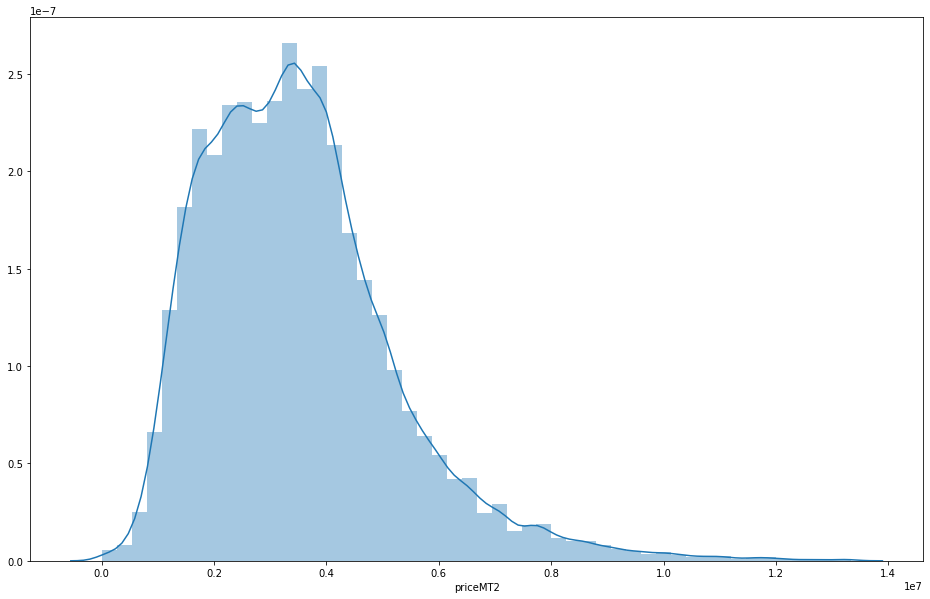

In [55]:
sns.distplot(houses_only['priceMT2'])

In [56]:
np.quantile(houses_only['priceMT2'],0.99)

9051646.122640034

In [57]:
houses_only['priceMT2'].describe()

count      56505.000
mean     3504964.200
std      1719086.782
min        12269.939
25%      2250000.000
50%      3313609.467
75%      4375000.000
max     13333333.333
Name: priceMT2, dtype: float64

In [194]:
encoder = OneHotEncoder(handle_unknown = 'ignore')
encoded = pd.DataFrame(encoder.fit_transform(train.dropna(subset=['tiempodeconstruido'])[['tiempodeconstruido']]).toarray())
encoded.columns = encoder.get_feature_names(['tiempodeconstruido'])
encoded

,tiempodeconstruido_1 a 8 años,tiempodeconstruido_16 a 30 años,tiempodeconstruido_9 a 15 años,tiempodeconstruido_Entre 0 y 5 años,tiempodeconstruido_Entre 10 y 20 años,tiempodeconstruido_Entre 5 y 10 años,tiempodeconstruido_Menos de 1 año,tiempodeconstruido_Más de 20 años,tiempodeconstruido_Más de 30 años,tiempodeconstruido_Remodelado,tiempodeconstruido_ntre 0 y 5 años
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
182132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
182133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
182134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
182135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [165]:
X

,longitud,latitud,estrato,conjuntocerrado,tiempodeconstruido_16 a 30 años,tiempodeconstruido_9 a 15 años,tiempodeconstruido_Entre 0 y 5 años,tiempodeconstruido_Entre 10 y 20 años,tiempodeconstruido_Entre 5 y 10 años,tiempodeconstruido_Menos de 1 año,tiempodeconstruido_Más de 20 años,tiempodeconstruido_Más de 30 años,tiempodeconstruido_Remodelado,tiempodeconstruido_ntre 0 y 5 años
0,-74.094889,4.560965,3.0,0,0,0,0,0,0,0,0,0,0,0
1,-74.100083,4.576960,NaN,0,0,0,0,0,0,0,0,0,0,0
2,-74.101000,4.575000,3.0,0,0,0,0,0,0,0,0,0,0,0
3,-74.108039,4.575924,3.0,0,0,0,0,0,0,0,0,0,0,0
4,-74.097000,4.559000,2.0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244483,-74.038282,4.737393,4.0,0,0,0,0,0,0,0,1,0,0,0
244484,-74.038518,4.734240,4.0,0,0,0,0,0,0,0,1,0,0,0
244485,-74.040659,4.736392,4.0,0,0,0,0,0,0,0,1,0,0,0
244486,-74.040292,4.737524,4.0,0,0,0,0,0,0,0,1,0,0,0


In [100]:
houses_only['conjuntocerrado'].value_counts()

0    43600
1    12905
Name: conjuntocerrado, dtype: int64

In [88]:
xgb_reg = xgb.XGBRegressor()

In [89]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [90]:
xgb_predictions = np.expm1(xgb_reg.predict(X_test)) 
real_price = np.expm1(y_test)

In [91]:
print(f"RMSE: {mean_squared_error(real_price, xgb_predictions)**0.5}")
print(f"MAE {mean_absolute_error(real_price, xgb_predictions)}")
print(f"MAPE: {mean_absolute_percentage_error(xgb_predictions, real_price)} ")

RMSE: 401550583.3661501
MAE 219746492.64056283
MAPE: 0.25236036320247984 


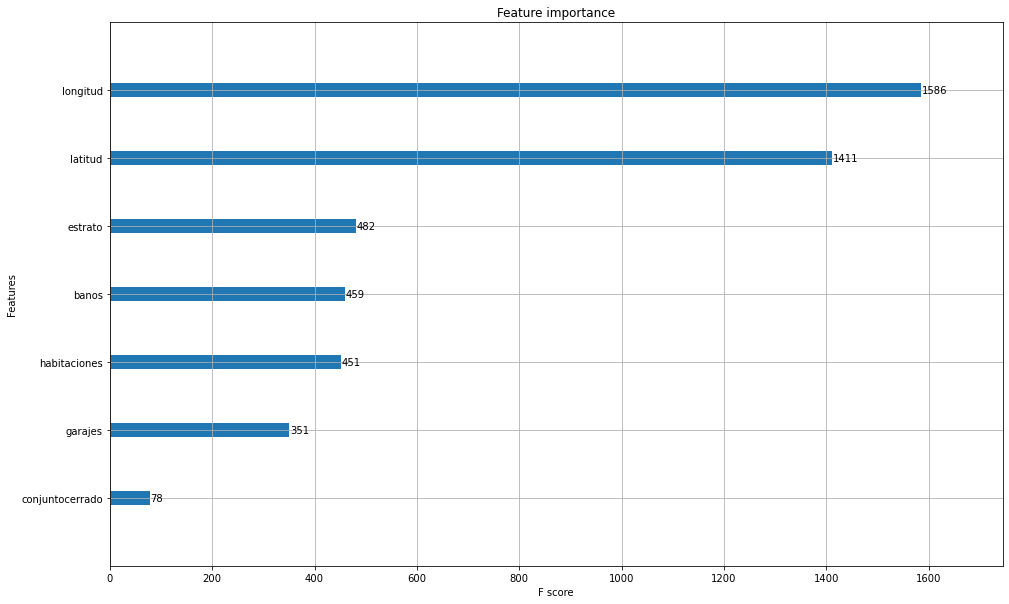

In [92]:
xgb.plot_importance(xgb_reg)

# Predictions

In [63]:
test = pd.read_csv("../data/test_data.csv")
test['priceMT2'] = test['valorventa'] / test['area']

test_predictions_df = DataFrameBuilder(test).process()
test_predictions_df

,id,area,ascensor,balcon,banos,banoservicio,conjuntocerrado,cuartoservicio,deposito,estrato,...,vigilancia,vista,zonalavanderia,valoradministracion,valorventa,tipoinmueble,tiponegocio,latitud,longitud,priceMT2
0,877392,104.000,nan,nan,2.000,nan,0,nan,nan,2.000,...,nan,NaN,1.000,0.000,185000000.000,Casa,Venta,4.712,-74.132,1778846.154
1,201483,144.000,nan,nan,2.000,nan,0,nan,1.000,3.000,...,1.000,NaN,1.000,0.000,498000000.000,Casa,Venta,4.701,-74.090,3458333.333
2,188674,144.000,nan,nan,2.000,nan,0,nan,nan,3.000,...,nan,NaN,nan,0.000,498000000.000,Casa,Venta,4.701,-74.090,3458333.333
3,1211067,145.000,nan,nan,2.000,nan,0,nan,1.000,3.000,...,1.000,NaN,1.000,0.000,519000000.000,Casa,Venta,4.703,-74.091,3579310.345
4,883437,145.000,nan,nan,2.000,nan,0,nan,1.000,3.000,...,1.000,NaN,1.000,0.000,517000000.000,Casa,Venta,4.701,-74.093,3565517.241
5,332550,145.000,nan,nan,2.000,nan,0,nan,1.000,3.000,...,1.000,NaN,1.000,0.000,514990000.000,Casa,Venta,4.702,-74.092,3551655.172
6,320585,145.000,nan,nan,2.000,nan,0,nan,1.000,3.000,...,1.000,NaN,1.000,0.000,510000000.000,Casa,Venta,4.699,-74.093,3517241.379
7,776969,145.000,nan,nan,2.000,nan,0,nan,1.000,3.000,...,1.000,NaN,nan,0.000,520000000.000,Casa,Venta,4.702,-74.092,3586206.897
8,435344,105.000,nan,nan,2.000,nan,0,nan,nan,2.000,...,nan,NaN,nan,0.000,215000000.000,Casa,Venta,4.710,-74.133,2047619.048
9,1274573,146.000,nan,nan,2.000,nan,0,nan,1.000,3.000,...,1.000,NaN,1.000,0.000,519000000.000,Casa,Venta,4.699,-74.091,3554794.521


In [94]:
test_predictions = np.expm1(xgb_reg.predict(test_predictions_df[features]))
print(f"RMSE: {mean_squared_error(test_predictions_df['valorventa'], test_predictions)**0.5}")
print(f"MAE {mean_absolute_error(test_predictions_df['valorventa'], test_predictions)}")
print(f"MAPE: {mean_absolute_percentage_error(test_predictions, test_predictions_df['valorventa'])} ")

RMSE: 66659941.1297576
MAE 50473596.679245286
MAPE: 0.11411628877197563 


In [95]:
submission = pd.read_csv("../data/example_submission.csv")
submission['valormt2_predicted'] = test_predictions / test_predictions_df['area']
submission.head()

,id,valormt2_predicted
0,188674,2022164.923
1,883437,3315475.333
2,320585,3315475.333
3,946955,3199229.793
4,425047,3199345.876


In [96]:
submission['valormt2_predicted'].unique()

array([2022164.92307692, 3315475.33333333, 3199229.79310345,
       3199345.87586207, 3242409.93103448, 3256926.23448276,
       2017006.47619048, 2616133.47945205, 3309128.10958904,
       2676396.2739726 , 3247812.57142857, 3286617.03401361,
       3212614.31292517, 2605025.70666667, 2297487.11111111,
       2281256.44444444, 2481580.66666667, 2284862.        ,
       2397377.85507246, 2346435.2       , 2363711.08571429,
       2363129.6       , 2349319.08571429, 3083747.62666667,
       3127927.46666667, 2918509.01333333, 2848169.1826087 ,
       3035499.96521739, 2894246.67826087, 3998248.62608696])

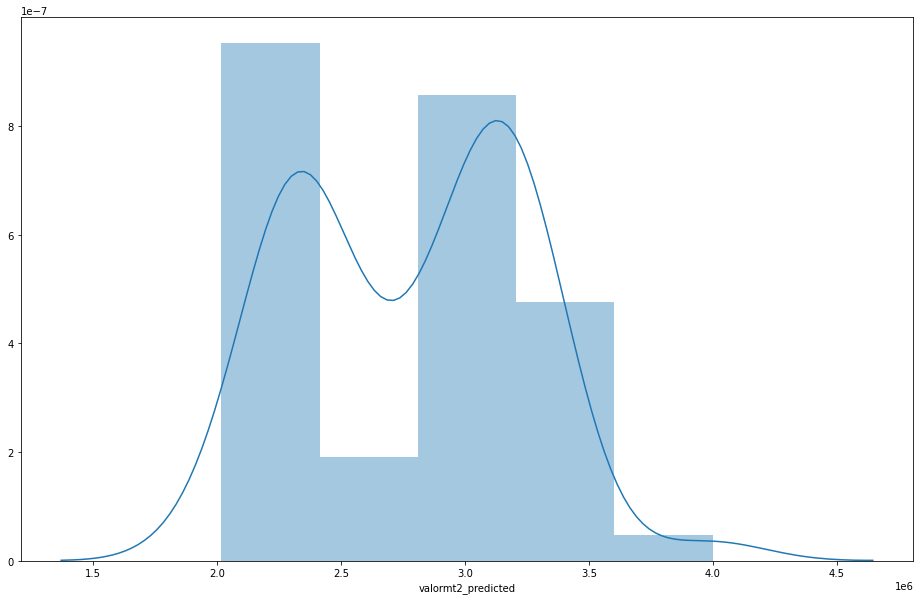

In [97]:
sns.distplot(submission['valormt2_predicted'])

In [98]:
submission.to_csv("xgbsubmission.csv", index=False)